In [1]:
from fastai2.vision.all import *

In [2]:
# On récupére un jeux d'images contenant des visages de personne. L'objectif va être ici de localiser le visage dans la 
# photo.

path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls(),(path/'01').ls()

# Le jeux contient x répertoires représentant x personnes. Pour chaque personne on va retrouver des couples images/fichiers
# texte. Le fichier texte contient la position de la tête dans l'image.

((#50) [Path('/storage/data/biwi_head_pose/16'),Path('/storage/data/biwi_head_pose/10.obj'),Path('/storage/data/biwi_head_pose/03'),Path('/storage/data/biwi_head_pose/16.obj'),Path('/storage/data/biwi_head_pose/19'),Path('/storage/data/biwi_head_pose/01'),Path('/storage/data/biwi_head_pose/20.obj'),Path('/storage/data/biwi_head_pose/13'),Path('/storage/data/biwi_head_pose/05.obj'),Path('/storage/data/biwi_head_pose/21')...],
 (#1000) [Path('/storage/data/biwi_head_pose/01/frame_00182_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00430_pose.txt'),Path('/storage/data/biwi_head_pose/01/frame_00304_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00103_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00091_pose.txt'),Path('/storage/data/biwi_head_pose/01/frame_00409_pose.txt'),Path('/storage/data/biwi_head_pose/01/frame_00239_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00282_rgb.jpg'),Path('/storage/data/biwi_head_pose/01/frame_00149_rgb.jpg'),Path('/storage/dat

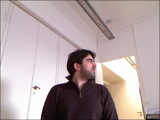

In [3]:
# Récupération des images
img_files = get_image_files(path)
# Exemple
PILImage.create(img_files[5]).to_thumb(160)

In [4]:
# Fonctions fournies avec le jeux de données pour déterminer le centre du visage à partir du fichier texte fourni
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_center(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, PointBlock), # PointBlock pour les coordonnées à déterminer
    get_items = get_image_files,
    get_y = get_center,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),#On prend une personne que le modèle n'a pas vu à l'entrainement
    batch_tfms = [*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)

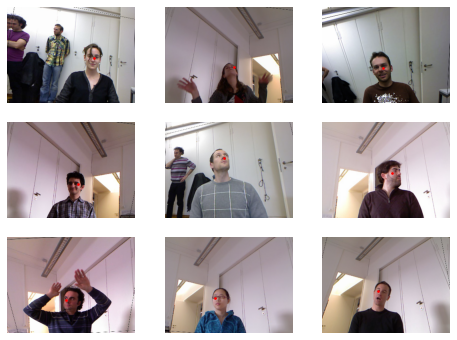

In [6]:
dls = dblock.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [7]:
xb,yb = dls.one_batch()
xb.shape,yb.shape 

# On retrouve des batchs de 64 items (défault) avec en entrée des images de 240 par 320 (3 canaux de couleurs) et en sortie
# des labels composés de deux coordonnées.

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [8]:
# On créer un modèle en précisant le "range" attendu en sortie afin d'améliorer ses performances. 

learn = cnn_learner(dls, resnet18, y_range=(-1,1))

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=7.585775847473997e-07)

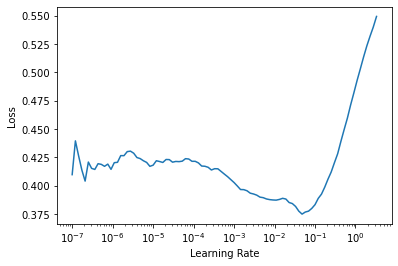

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,0.045575,0.016845,00:49
1,0.006465,0.000677,00:48
2,0.002972,0.000629,00:48
3,0.002058,0.000678,00:48
4,0.001542,0.000212,00:48
